# Comparison between using k_folds=5 and k_folds=2 in Neuroprobe Lite.
This notebook shows that using 2 folds instead of 5 folds for cross-validation in Neuroprobe Lite yields nearly identical results, while being approximately 4x faster to evaluate. The comparison is done across all subjects and trials in the Neuroprobe Lite dataset.

To reproduce the analysis, first you will need to evaluate a model (here, a linear model) on Neuroprobe Lite, and then modify the config in neuroprobe/config.py, variable NEUROPROBE_LITE_N_FOLDS to increase it to 5 folds, and re-run the evaluation analysis again (but now saving to a different folder). Then, run all the cells in this notebook!

In [1]:
import torch
import neuroprobe.config as neuroprobe_config
from neuroprobe.braintreebank_subject import BrainTreebankSubject
from neuroprobe.datasets import BrainTreebankSubjectTrialBenchmarkDataset
import numpy as np
import json, os

def load_results(dirname, subject_trials):
    results_array = np.zeros((len(subject_trials), len(neuroprobe_config.NEUROPROBE_TASKS)))
    for st_i, (subject_id, trial_id) in enumerate(subject_trials):
        for t_i, task_name in enumerate(neuroprobe_config.NEUROPROBE_TASKS):
            results_path = os.path.join(dirname, f"population_btbank{subject_id}_{trial_id}_{task_name}.json")
            with open(results_path, "r") as f:
                results = json.load(f)
                results = results["evaluation_results"][f"btbank{subject_id}_{trial_id}"]["population"]["one_second_after_onset"]
                results = np.mean([fold["test_roc_auc"] for fold in results["folds"]])
            results_array[st_i, t_i] = results
    return results_array

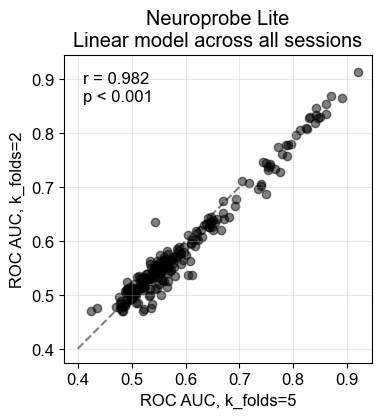

Correlation coefficient: 0.982
P-value: 9.28091224702714e-165


In [3]:
NEUROPROBE_LITE_kf5_RESULTS = load_results("data/eval_results_lite_kf5_SS_SM/linear_voltage", neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS)
NEUROPROBE_LITE_kf2_RESULTS = load_results("data/eval_results_lite_SS_SM/linear_voltage", neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS)

import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Flatten arrays to 1D for correlation plot
lite_flat = NEUROPROBE_LITE_kf5_RESULTS.flatten()
lite_kf2_flat = NEUROPROBE_LITE_kf2_RESULTS.flatten()
# Calculate correlation coefficient and p-value
from scipy import stats
r, p = stats.pearsonr(lite_flat, lite_kf2_flat)

plt.figure(figsize=(4, 4))
plt.scatter(lite_flat, lite_kf2_flat, alpha=0.5, color='black')
plt.plot([0.4, 0.7], [0.4, 0.7], 'k--', alpha=0.5) # Plot y=x line

plt.xlabel('ROC AUC, k_folds=5')
plt.ylabel('ROC AUC, k_folds=2') 
plt.title('Neuroprobe Lite\nLinear model across all sessions')

# Add correlation text
plt.text(0.41, 0.86, f'r = {r:.3f}\np < 0.001', fontsize=12)

# Make axes equal and set limits
plt.axis('square')
# plt.xlim(0.4, 0.7)
# plt.ylim(0.4, 0.7)

plt.grid(True, alpha=0.3)
plt.show()

# Print correlation coefficient
print(f"Correlation coefficient: {r:.3f}")
print(f"P-value: {p}")
